# This is QC on all tumors that have matched tumor pattern

## 1 Functions and module

### 1.1 Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import seaborn as sns
import re
import scipy.stats as SS
%matplotlib inline 
import copy
import scipy

In [2]:
pd.set_option('display.max_columns', None)

### 1.2 Functions

In [3]:
def Final_df_Generation(input_df,input_conversion_factor_df):
    # input_df is the dataframe input
    # input_conversion_factor_df is the dictionary that store the the cell number per reads
    temp_df = input_df.merge(input_conversion_factor_df, on ='Sample_ID')
    temp_df['Cell_number'] = temp_df['Count']*temp_df['Cell_number_per_read']
    return(temp_df)

In [4]:
def Cas12a_array_combination(input_df, n):
    """
    This function creates different combinations of gRNA and gene columns 
    based on the input DataFrame and number of guides/genes provided.
    
    Parameters:
    input_df (DataFrame): The input DataFrame containing gRNA and gene information.
    n (int): The number of gRNAs/genes columns to be combined.

    Returns:
    DataFrame: A new DataFrame with additional columns for ordered and unordered combinations.
    """
    # Copy the input DataFrame to avoid modifying the original
    temp_df = input_df.copy()

    # Generate the list of gRNA and gene column names dynamically based on n
    gRNA_columns = [f'gRNA{i}' for i in range(1, n + 1)]
    gene_columns = [f'Gene{i}' for i in range(1, n + 1)]

    # Generate combinations at gRNA and gene levels
    temp_df['gRNA_combination'] = temp_df[gRNA_columns].agg('_'.join, axis=1)
    temp_df['gRNA_combination_unordered'] = temp_df[gRNA_columns].agg(lambda row: '_'.join(sorted(row)), axis=1)

    temp_df['gene_combination'] = temp_df[gene_columns].agg('_'.join, axis=1)
    temp_df['gene_combination_unordered'] = temp_df[gene_columns].agg(lambda row: '_'.join(sorted(row)), axis=1)

    return temp_df


In [5]:
def Generate_Dataframe_Cas12a(read_df, gRNA_df, mice_df, n, barcode_pattern=False):
    """
    This function generates a combined DataFrame by merging read, gRNA, and mice data, 
    with an optional feature to filter by barcode pattern.
    
    Parameters:
    - read_df (DataFrame): The DataFrame containing read information.
    - gRNA_df (DataFrame): The DataFrame containing gRNA and gene information.
    - mice_df (DataFrame): The DataFrame containing mice metadata.
    - n (int): The number of gRNA per array (array size).
    - barcode_pattern (str or bool, optional): A regex pattern for filtering barcodes.
    
    Returns:
    - DataFrame: The final combined DataFrame.
    """
    # Generate column names dynamically based on array size (n)
    gRNA_columns = [f'gRNA{i}' for i in range(1, n + 1)]
    gene_columns = [f'Gene{i}' for i in range(1, n + 1)]
    guide_columns = [f'Guide{i}' for i in range(1, n + 1)]

    temp_gRNA_info_columns = ['gRNA_combination', 'gene_combination', 
                              'gene_combination_unordered', 'gRNA_combination_unordered', 
                              'Array_category']

    # Combine all required columns into a list
    required_gRNA_columns = gRNA_columns + gene_columns + guide_columns + temp_gRNA_info_columns

    # Check if gRNA_df contains all required columns
    missing_gRNA_columns = [col for col in required_gRNA_columns if col not in gRNA_df.columns]
    if missing_gRNA_columns:
        raise ValueError(f"The following required columns are missing from gRNA_df: {missing_gRNA_columns}")

    # Define the columns from mice_df to merge
    mice_columns = ['Sample_ID', 'Mouse_genotype', 'Virus_titer', 'Time_after_tumor_initiation', 
                    'Total_lung_weight', 'Sex']

    # Check if mice_df contains all required columns
    missing_mice_columns = [col for col in mice_columns if col not in mice_df.columns]
    if missing_mice_columns:
        raise ValueError(f"The following required columns are missing from mice_df: {missing_mice_columns}")

    # Merge read_df with gRNA_df on shared gRNA columns and combination column
    temp_shared_columns = gRNA_columns + ['gRNA_combination']
    read_df = read_df.merge(gRNA_df, on=temp_shared_columns, how='left')

    # Merge read_df with mice_df on 'Sample_ID'
    Output_df = read_df.merge(mice_df[mice_columns], on='Sample_ID', how='left')

    # If barcode_pattern is provided, filter the Output_df by the specified pattern
    if barcode_pattern:
        # Compile the regex pattern
        temp_pattern = regex.compile(barcode_pattern)

        # Initialize the 'Project_barcode' column with 'Spikein_barcode'
        Output_df['Project_barcode'] = 'Spikein_barcode'

        # Apply regex pattern to 'Clonal_barcode' to determine match status
        Output_df.loc[Output_df['Array_category'] != 'Spikein', 'Project_barcode'] = Output_df.loc[
            Output_df['Array_category'] != 'Spikein', 'Clonal_barcode'
        ].apply(lambda x: 'Match' if temp_pattern.search(x) else 'Unmatch')
    else:
        Output_df['Project_barcode'] = 'Spikein_barcode'
        Output_df.loc[Output_df['Array_category'] != 'Spikein', 'Project_barcode'] = 'No_pattern'
    
    return Output_df



In [6]:
import pandas as pd
import numpy as np

def Spikein_summary_Cas12a(input_df, input_cell_number):
    """
    This function extracts spike-in reads for each kind in each sample and assigns a unique name for each spike-in.
    
    Parameters:
    - input_df (DataFrame): The input DataFrame containing reads and metadata.
    - input_cell_number (int or float): Total cell number used to calculate 'Cell_per_read'.
    
    Returns:
    - DataFrame: A summary DataFrame containing information about spike-ins per sample.
    """
    
    # Select spike-in rows only
    temp_df = input_df[input_df['Array_category'] == 'Spikein']
    
    # Group by 'Sample_ID' and 'gRNA_combination', aggregating the required metrics
    temp_df = temp_df.groupby(['Sample_ID', 'gRNA_combination'], as_index=False).agg(
        Unique_spikein_barcode_number=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x.unique())),  # Number of unique spike-in barcodes
        Count=pd.NamedAgg(column='Count', aggfunc=np.sum)
    )
    
    # Sort and assign a unique name to each unique 'gRNA_combination' per 'Sample_ID'
    temp_df = temp_df.sort_values(by=['Sample_ID', 'gRNA_combination']).reset_index(drop=True)
    
    # Assigning 'Spikein1', 'Spikein2', etc. to each unique gRNA_combination per sample
    temp_df['Spikein_name'] = temp_df.groupby('Sample_ID').cumcount().apply(lambda x: f'Spikein{x + 1}')
    
    # Calculate 'Cell_per_read'
    temp_df['Cell_per_read'] = input_cell_number / temp_df['Count']
    
    # Calculate 'Amplification' as Count per unique spike-in barcode
    temp_df['Amplification'] = temp_df['Count'] / temp_df['Unique_spikein_barcode_number']
    
    return temp_df

# Example usage (assuming `input_df` is defined with the required columns):
# spikein_summary = Spikein_summary_Cas12a(input_df, input_cell_number=10000)
# print(spikein_summary)


In [7]:
import pandas as pd

# Assuming spikein_df is already defined with 'Sample_ID', 'gRNA_combination', and 'Count' columns

def cal_spikein_ratio(x):
    """
    Calculate the ratios between spike-in gRNA counts for a given sample.
    
    Parameters:
    - x (DataFrame): Subset of spikein_df containing data for a single 'Sample_ID'.
    
    Returns:
    - Series: A pandas Series containing mean count, spike-in ratios, and the max-to-least ratio.
    """
    d = {}
    
    # Extract the count values for each unique 'gRNA_combination' and sort by 'gRNA_combination'
    temp_vect = x[['gRNA_combination', 'Count','Spikein_name']].sort_values(by='gRNA_combination').reset_index(drop=True)
    
    # Ensure there are exactly three unique gRNA_combinations
    unique_gRNAs = temp_vect['gRNA_combination'].unique()
    if len(unique_gRNAs) != 3:
        raise ValueError(f"Expected 3 unique gRNA_combinations for Sample_ID {x['Sample_ID'].iloc[0]}, "
                         f"but found {len(unique_gRNAs)}")


    
    # Extract count values for each of the three gRNAs
    s1_value = temp_vect['Count'].iloc[0]
    s2_value = temp_vect['Count'].iloc[1]
    s3_value = temp_vect['Count'].iloc[2]

    # Calculate the mean count
    d['Mean_count'] = (s1_value + s2_value + s3_value) / 3
    
    # Calculate ratios, avoiding division by zero
    d['s1_s2_ratio'] = s1_value / s2_value if s2_value != 0 else None
    d['s1_s3_ratio'] = s1_value / s3_value if s3_value != 0 else None

    # Calculate max-to-least ratio
    values_sorted = sorted([s1_value, s2_value, s3_value])
    d['max_least_ratio'] = values_sorted[-1] / values_sorted[0] if values_sorted[0] != 0 else None
    # Extract gRNA combination names and count values
    d['Spikein1'] = temp_vect['gRNA_combination'].iloc[0]
    d['Spikein2'] = temp_vect['gRNA_combination'].iloc[1]
    d['Spikein3'] = temp_vect['gRNA_combination'].iloc[2]
    return pd.Series(d)

In [8]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size = 8)

In [9]:
def Generate_Conversion_factor(input_spike_df, input_candidate_list, input_spike_in_list,temp_spikein_cell_number):
    # this function generate a df storing cell number per reads
    # input_spike_df is the df contain the spikein information (spikein_ratio_df)
    # temp_spikein_cell_number is the cell number for each spike in added into sample (usually it is 100K)
    # for most sample, I will use temp_spikein_cell_number/ mean(spike in reads)
    # input_candidate_list is the list of sample id whose spikein needed special treatment
    # temp_spikein_cell_number specify which spike in will be use for each sample ID who need special treatment
    input_dic = dict(zip(input_candidate_list, input_spike_in_list))
    temp_dic = {}
    for index,row in input_spike_df.iterrows():
        temp_id = row['Sample_ID']
        if temp_id in input_dic.keys():
            # print(row[input_dic.get(id)])
            temp_value = row[input_dic.get(temp_id)].mean()
        else:
            temp_value = row['Mean_count']
        temp_dic[temp_id] = temp_spikein_cell_number/temp_value
    temp_df = pd.DataFrame({'Sample_ID':temp_dic.keys(),
                       'Cell_number_per_read':temp_dic.values()})
    temp_df['Correction_for_spikein'] = temp_df['Sample_ID'].apply(lambda x: 'Yes' if (x in input_candidate_list) else 'No')
    return(temp_df.sort_values(by=['Correction_for_spikein','Cell_number_per_read']))

In [10]:
# calculate the summary metrics for each sample
def Cal_Sample_Summary(x):
    d = {}
    temp_vect = x['Cell_number']
    if type (temp_vect) == 'int':
        temp_vect = [temp_vect]
    d['array_recovered'] = len(x['gRNA_combination'].unique())
    d['TTB'] = sum(temp_vect) # total mutational burdern 
    d['TTN'] = len(temp_vect) # this is total tumor number
    return pd.Series(d, index=list(d.keys())) 

In [11]:
def Generate_Sample_Summary_Ca12a(input_df, input_spikein_check_df,input_cell_number_cutoff,input_read_cutoff):
    # input_cell_number_cutoff is the cell number cutoff
    # input_rad_cutoff is the read cutoff
    # Total reads does not restricted to gRNA or cell number cutoff
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_genotype', 'Sex',
         'Time_after_tumor_initiation', 'Total_lung_weight', 'Virus_titer','Correction_for_spikein','Cell_number_per_read'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum))
    temp_df0 = temp_df0.merge(input_spikein_check_df[['Sample_ID','Mean_count','max_least_ratio']],on = 'Sample_ID') # merge spike in info
    temp_df0['Spikein_read_ratio'] = (temp_df0['Mean_count']*3)/(temp_df0['TTR']+(temp_df0['Mean_count']*3))
    # filter input data
    temp_input = input_df[(input_df['Cell_number']>=input_cell_number_cutoff)&(input_df['Count']>input_read_cutoff)]
    # I only consider non-spikein gRNA
    temp_df1 = temp_input.groupby(
        ['Sample_ID'],as_index = False).apply(
        Cal_Sample_Summary)
    temp_df1['TTB_million'] = temp_df1['TTB']/1000000
    # merge sample and gRNA information    
    temp_df1 = temp_df1.merge(temp_df0,on = 'Sample_ID',how = 'right')
    return(temp_df1)

----

## 2 Input and output address

In [12]:
project_dir = "/labs/mwinslow/Haiqing/UltraSeq_Projects/Cas12a_3guide_example/"
data_address = project_dir + "01_data_collection/data/Processed_data/gRNA_clonalbarcode_combined.csv"
working_dir = project_dir+"02_data_cleaning_and_QC/data/"
# gRNA information address
gRNA_info_address = working_dir + "guide_reference-cas12a_triple_KO.csv"
# experimental information address
exp_info_address = working_dir + "Mice_info_standardized_Cas12a_TripleKnockout.csv"

In [13]:
cell_line_number = 100000

In [14]:
project_prefix = 'Cas12a_TK'
sample_summary_address = working_dir + f"{project_prefix}_sample_summary_df.csv"
annotated_data_output_address = working_dir + f"{project_prefix}_annotated_df.parquet"
final_data_output_address = working_dir + f"{project_prefix}_final_df.parquet"

---

## 3 Data Input and simple QC

### 3.1 Read mice info

In [15]:
mice_info = pd.read_csv(exp_info_address)

In [16]:
mice_info.rename(columns = {'Sample ID':'Sample_ID','Mouse_Genotype':'Mouse_genotype',
                            'Virus_Titer':'Virus_titer','Time_After_Tumor_Initiation(wks)':'Time_after_tumor_initiation',
                                 'Total_Lung_Weight(g)':'Total_lung_weight'}, inplace = True)

### 3.2 Read NGS data for tumor

In [20]:
raw_df = pd.read_csv(data_address)

### 3.3 Read gRNA info

In [24]:
ref_df = pd.read_csv(gRNA_info_address)
ref_df = ref_df.rename(columns={'Guide1_sequence':'gRNA1','Guide2_sequence':'gRNA2','Guide3_sequence':'gRNA3',
                               })

In [25]:
ref_df.head()

,Guide1,Guide2,Guide3,Gene1,Gene2,Gene3,Array_category,gRNA1,gRNA2,gRNA3,crRNA sequence,Array_count,DR1,DR2,DR3,DR6,gRNA_combination
0,Lkb1_1,Keap1_1,Rbm10_2,Lkb1,Keap1,Rbm10,Triple_TSG,CGGCGCGGCTGGTAGATTACCTC,GCGTCATGAACGAGCTTCGCCTG,CCACAGCACTCCCTCAACATCCT,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATCGGCGCGGCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,CGGCGCGGCTGGTAGATTACCTC_GCGTCATGAACGAGCTTCGCCT...
1,Lkb1_1,Keap1_1,Rbm10_1,Lkb1,Keap1,Rbm10,Triple_TSG,CGGCGCGGCTGGTAGATTACCTC,GCGTCATGAACGAGCTTCGCCTG,CTGAACAGATCCGTGGACAGCTG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATCGGCGCGGCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,CGGCGCGGCTGGTAGATTACCTC_GCGTCATGAACGAGCTTCGCCT...
2,Lkb1_1,Keap1_1,Mga_1,Lkb1,Keap1,Mga,Triple_TSG,CGGCGCGGCTGGTAGATTACCTC,GCGTCATGAACGAGCTTCGCCTG,GAGAAGGCTCCCCATAATGTAAA,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATCGGCGCGGCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,CGGCGCGGCTGGTAGATTACCTC_GCGTCATGAACGAGCTTCGCCT...
3,Lkb1_1,Keap1_1,Mga_2,Lkb1,Keap1,Mga,Triple_TSG,CGGCGCGGCTGGTAGATTACCTC,GCGTCATGAACGAGCTTCGCCTG,GCTTTAGCAACACCTGGGCTATT,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATCGGCGCGGCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,CGGCGCGGCTGGTAGATTACCTC_GCGTCATGAACGAGCTTCGCCT...
4,Lkb1_1,Keap1_1,Arid1a_1,Lkb1,Keap1,Arid1a,Triple_TSG,CGGCGCGGCTGGTAGATTACCTC,GCGTCATGAACGAGCTTCGCCTG,TGGCGGGAGTTAACTTAACATCC,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATCGGCGCGGCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,CGGCGCGGCTGGTAGATTACCTC_GCGTCATGAACGAGCTTCGCCT...


In [26]:
ref_df = Cas12a_array_combination(ref_df,3)

### 3.4 Merge all df

In [25]:
temp_raw_read = Generate_Dataframe_Cas12a(raw_df,ref_df,mice_info,3,barcode_pattern='(T.{4}A.{4}C.{4}G)')

In [26]:
temp_raw_read = temp_raw_read[temp_raw_read.Clonal_barcode!='CTTGAGAGGCCATGTT'] # exclude barcode filler

### 3.5 Simple summary 

In [27]:
temp_raw_read.Project_barcode.unique()

array(['Match', 'Unmatch', 'Spikein_barcode'], dtype=object)

In [28]:
temp1 = temp_raw_read[temp_raw_read.Project_barcode!='Spikein_barcode']['Count'].sum() # match + umatch barcode
temp2 = temp_raw_read[temp_raw_read.Project_barcode=='Match']['Count'].sum() # match barcode
print(f'{temp2/temp1:.1%} reads have expected barcode pattern, which is about {temp2:.1e} reads')

99.6% reads have expected barcode pattern, which is about 5.6e+07 reads


In [29]:
processed_df = temp_raw_read[temp_raw_read.Project_barcode!='Unmatch'].copy()

In [30]:
# Group by 'Sample_ID' and calculate both sum and count
result = processed_df.groupby(['Sample_ID','Array_category','Mouse_genotype'], as_index=False).agg(
    read_sum=('Count', 'sum'),  # Sum of 'Count'
)
result.head()

,Sample_ID,Array_category,Mouse_genotype,read_sum
0,LA87_01,Double_DT,KTCas12a,25730
1,LA87_01,Double_DT_Single_TSG,KTCas12a,237194
2,LA87_01,Double_TSG,KTCas12a,986917
3,LA87_01,Single_DT,KTCas12a,14866
4,LA87_01,Single_DT_Single_TSG,KTCas12a,360432


----

## 4 Spikein QC

### 4.1 Count spikein read numbers and ratio

In [32]:
# I first check if spikes have similar read counts 
spikein_df = Spikein_summary_Cas12a(processed_df,cell_line_number)

In [33]:
spikein_df.head()

,Sample_ID,gRNA_combination,Unique_spikein_barcode_number,Count,Spikein_name,Cell_per_read,Amplification
0,LA87_01,ATCGGACTACGCCGATCGGAGGG_GTTCGTGTCGACTCGCGTAATG...,1527,13484,Spikein1,7.416197,8.830386
1,LA87_01,GCGCGACGCCGTAACTTGCCTCG_CCGCGACGAATACGCGCGAGTC...,1901,17551,Spikein2,5.697681,9.232509
2,LA87_01,GTATTACGTCGAGCCGACGAACT_CCCGTTCGACGCGCGATAAAAC...,1823,15805,Spikein3,6.327112,8.669775
3,LA87_02,ATCGGACTACGCCGATCGGAGGG_GTTCGTGTCGACTCGCGTAATG...,1827,11515,Spikein1,8.684325,6.302682
4,LA87_02,GCGCGACGCCGTAACTTGCCTCG_CCGCGACGAATACGCGCGAGTC...,2288,15209,Spikein2,6.575054,6.647290


In [34]:
# Apply the function to the DataFrame grouped by 'Sample_ID'
spikein_ratio_df = spikein_df.groupby('Sample_ID', as_index=False).apply(cal_spikein_ratio)

In [35]:
spikein_ratio_df.head()

,Sample_ID,Mean_count,s1_s2_ratio,s1_s3_ratio,max_least_ratio,Spikein1,Spikein2,Spikein3
0,LA87_01,15613.333333,0.768275,0.853148,1.301617,ATCGGACTACGCCGATCGGAGGG_GTTCGTGTCGACTCGCGTAATG...,GCGCGACGCCGTAACTTGCCTCG_CCGCGACGAATACGCGCGAGTC...,GTATTACGTCGAGCCGACGAACT_CCCGTTCGACGCGCGATAAAAC...
1,LA87_02,13366.000000,0.757117,0.860999,1.320799,ATCGGACTACGCCGATCGGAGGG_GTTCGTGTCGACTCGCGTAATG...,GCGCGACGCCGTAACTTGCCTCG_CCGCGACGAATACGCGCGAGTC...,GTATTACGTCGAGCCGACGAACT_CCCGTTCGACGCGCGATAAAAC...
2,LA87_03,9246.666667,0.859155,0.962872,1.163934,ATCGGACTACGCCGATCGGAGGG_GTTCGTGTCGACTCGCGTAATG...,GCGCGACGCCGTAACTTGCCTCG_CCGCGACGAATACGCGCGAGTC...,GTATTACGTCGAGCCGACGAACT_CCCGTTCGACGCGCGATAAAAC...
3,LA87_04,10996.666667,0.783872,0.870347,1.275719,ATCGGACTACGCCGATCGGAGGG_GTTCGTGTCGACTCGCGTAATG...,GCGCGACGCCGTAACTTGCCTCG_CCGCGACGAATACGCGCGAGTC...,GTATTACGTCGAGCCGACGAACT_CCCGTTCGACGCGCGATAAAAC...
4,LA87_05,13490.666667,0.858486,0.998516,1.164841,ATCGGACTACGCCGATCGGAGGG_GTTCGTGTCGACTCGCGTAATG...,GCGCGACGCCGTAACTTGCCTCG_CCGCGACGAATACGCGCGAGTC...,GTATTACGTCGAGCCGACGAACT_CCCGTTCGACGCGCGATAAAAC...


### 4.2 Find samples with unusual spike in ratio

Text(0, 0.5, 's1/s3')

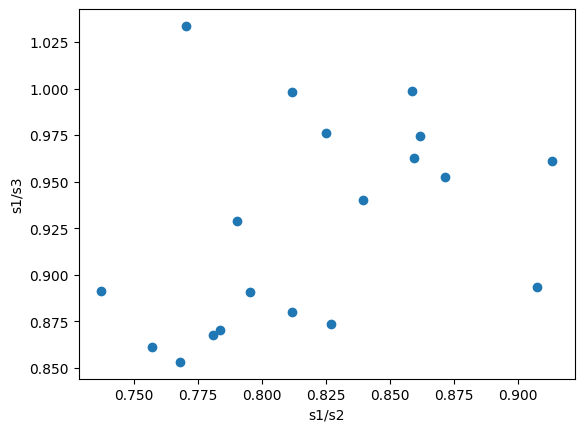

In [36]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
# label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
# plt.xscale('log',base = 2)
# plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

Text(0, 0.5, 's1/s3')

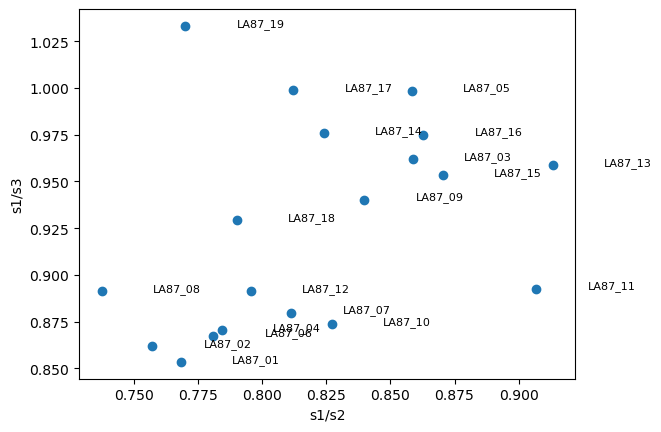

In [49]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
# plt.xscale('log',base = 2)
# plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

<font size="5" color =  black> <mark>No samples</mark> have relatively distorted ratio between spikein</font>

### 4.3 Find bad spike in for those samples

#### 4.3.1 Method 1

In [37]:
input_ratio_cutoff = 1.3 # this is the cutoff 
temp_bad_list = spikein_ratio_df.loc[spikein_ratio_df['max_least_ratio']>input_ratio_cutoff,'Sample_ID'].to_list() # list of sample with bad spikein

Text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>1.3)')

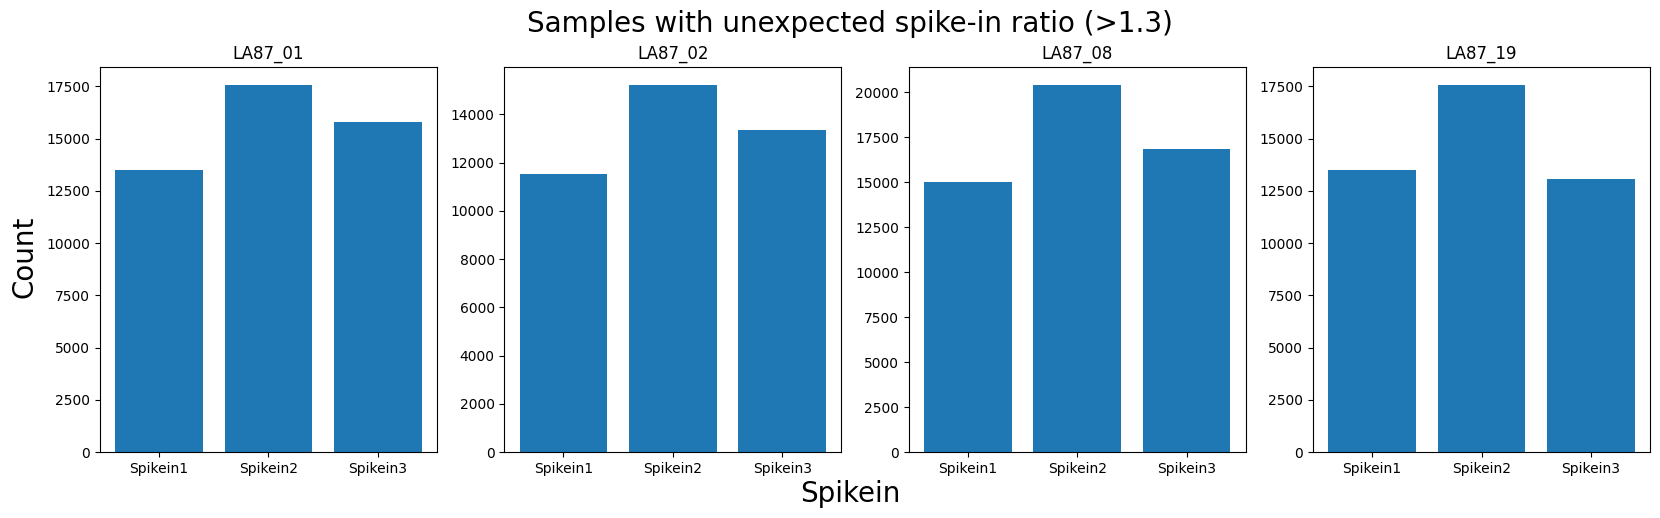

In [38]:
# check the max/min ratio in each sample and print those sample with ratio above certain cutoff
fig1,ax = plt.subplots(math.ceil(len(temp_bad_list)/4), 4, figsize=(20,5*math.ceil(len(temp_bad_list)/4)))
axes = ax.flatten()
for x,y in zip(axes[:len(temp_bad_list)],temp_bad_list):
    temp_df = spikein_df[spikein_df['Sample_ID'] == y]
    x.bar(temp_df['Spikein_name'],temp_df['Count'])
    x.set_title(y)
for x in axes[len(temp_bad_list):]:
    x.set_axis_off()
fig1.text(0.08, 0.5, 'Count', va='center', rotation='vertical',fontsize=20)
fig1.text(0.5, 0.01, 'Spikein', ha='center',fontsize=20)
fig1.text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>{})'.format(input_ratio_cutoff), ha='center',fontsize=20)
# fig1.savefig(figure_output_address+'QC_332.pdf')aa

<font size="5" color =  black>All samples looks fine to me</font>


#### 4.3.2 Method 2

In [39]:
def Generate_Simple_Sample_Summary(input_df,input_spikein_df):
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_genotype','Virus_titer','Total_lung_weight'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum)) # total reads
    temp_spike_df = input_spikein_df.set_index('Sample_ID')
    temp_df0['Spike1_reads_fraction'] = temp_spike_df[temp_spike_df['Spikein_name']=='Spikein1'].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike2_reads_fraction'] = temp_spike_df[temp_spike_df['Spikein_name']=='Spikein2'].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike3_reads_fraction'] = temp_spike_df[temp_spike_df['Spikein_name']=='Spikein3'].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    return(temp_df0)

In [40]:
temp_summary_df = Generate_Simple_Sample_Summary(processed_df,spikein_df)

In [41]:
temp_summary_df.head()

,Sample_ID,Mouse_genotype,Virus_titer,Total_lung_weight,TTR,Spike1_reads_fraction,Spike2_reads_fraction,Spike3_reads_fraction
0,LA87_01,KTCas12a,500000.0,0.2855,4499640,0.002997,0.003901,0.003513
1,LA87_02,KTCas12a,500000.0,0.2059,2004908,0.005743,0.007586,0.006671
2,LA87_03,KTCas12a,500000.0,0.2154,1128525,0.007676,0.008934,0.007971
3,LA87_04,KTCas12a,500000.0,0.4316,7623057,0.001264,0.001612,0.001452
4,LA87_05,KTHCas12a,500000.0,0.2648,3453557,0.003701,0.004311,0.003707


<Axes: xlabel='Mouse_genotype', ylabel='Spike1_reads_fraction'>

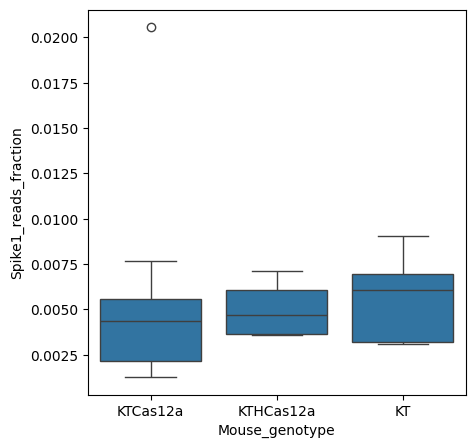

In [44]:
gs = gridspec.GridSpec(1, 17) 
fig1 = plt.figure(figsize=(17,5))
ax1=fig1.add_subplot(gs[:1, 0:5])
temp_df = temp_summary_df
ix = 'Mouse_genotype'
iy = 'Spike1_reads_fraction'
# sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax1,hue = 'Pooling_library_name',)
sns.boxplot(data=temp_df, x=ix,y =iy , ax = ax1)
# ax1.set_yscale('log', base=10)

In [56]:
temp_df.groupby('Mouse_genotype', as_index=False)['Spike1_reads_fraction'].mean()

,Mouse_genotype,Spike1_reads_fraction
0,KT,0.005691
1,KTCas12a,0.005566
2,KTHCas12a,0.005018


In [57]:
temp_df.groupby('Mouse_genotype', as_index=False)['Spike2_reads_fraction'].mean()

,Mouse_genotype,Spike2_reads_fraction
0,KT,0.006991
1,KTCas12a,0.006567
2,KTHCas12a,0.006300


In [58]:
temp_df.groupby('Mouse_genotype', as_index=False)['Spike3_reads_fraction'].mean()

,Mouse_genotype,Spike3_reads_fraction
0,KT,0.005767
1,KTCas12a,0.006009
2,KTHCas12a,0.005588


In [60]:
temp_summary_df[['Mouse_genotype']].value_counts()

Mouse_genotype
KTCas12a          10
KT                 5
KTHCas12a          4
dtype: int64

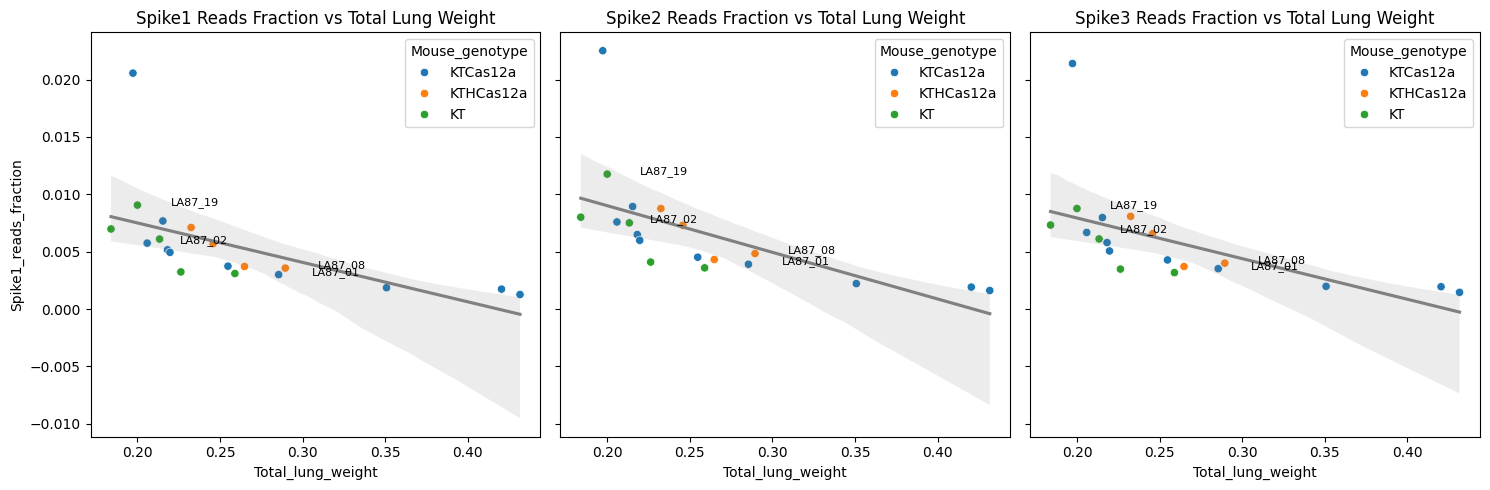

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Set common x-axis label
ix = 'Total_lung_weight'

# Define y-axis values and titles for each subplot
y_axes = ['Spike1_reads_fraction', 'Spike2_reads_fraction', 'Spike3_reads_fraction']
titles = ['Spike1 Reads Fraction vs Total Lung Weight', 'Spike2 Reads Fraction vs Total Lung Weight', 'Spike3 Reads Fraction vs Total Lung Weight']

temp_xlim = (0.1,0.9)
# Iterate through each subplot to plot the data
for ax, iy, title in zip(axes, y_axes, titles):
    temp_df = temp_summary_df
    
    # Scatter plot for actual data points, hue representing 'Pooling_library_name'
    sns.scatterplot(data=temp_df, x=ix, y=iy,ax=ax, hue = 'Mouse_genotype')
    
    # Linear regression plot (line only)
    sns.regplot(data=temp_df, x=ix, y=iy, ax=ax, scatter=False, line_kws={"color": "grey"})
    
    # Labeling specific points using label_point function
    temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
    label_point(temp_sub[ix], temp_sub[iy], temp_sub['Sample_ID'], ax)
    # ax.set_xlim(temp_xlim)
    # Set the title for each subplot
    ax.set_title(title)

# Improve layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()


----

## 5 Correct cell number

### 5.1 COrrect cell number based on spike in 

In [46]:
# temp = [['tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'],['tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'],['tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3']]
temp = []
conversion_factor_df= Generate_Conversion_factor(spikein_ratio_df,[],temp,cell_line_number)

In [47]:
anotated_df = Final_df_Generation(processed_df,conversion_factor_df)
anotated_df = anotated_df[~anotated_df.gene_combination_unordered.isna()]

### 5.2 Output data

In [48]:
anotated_df.to_parquet(annotated_data_output_address,index =False)

In [17]:
# anotated_df = pd.read_parquet(annotated_data_output_address)

----

## 6 Overall sample QC 

### 6.1 Explaination

In [49]:
cell_number_cutoff = 100
# use non-spikein data
Sample_summary_df =  Generate_Sample_Summary_Ca12a(anotated_df[anotated_df.Array_category!='Spikein'], spikein_ratio_df,cell_number_cutoff,2)

### 6.2 Output data

In [50]:
Sample_summary_df.to_csv(sample_summary_address, index=False)

### 6.3 Plotting

Text(0, 0.5, 'Total tumor number')

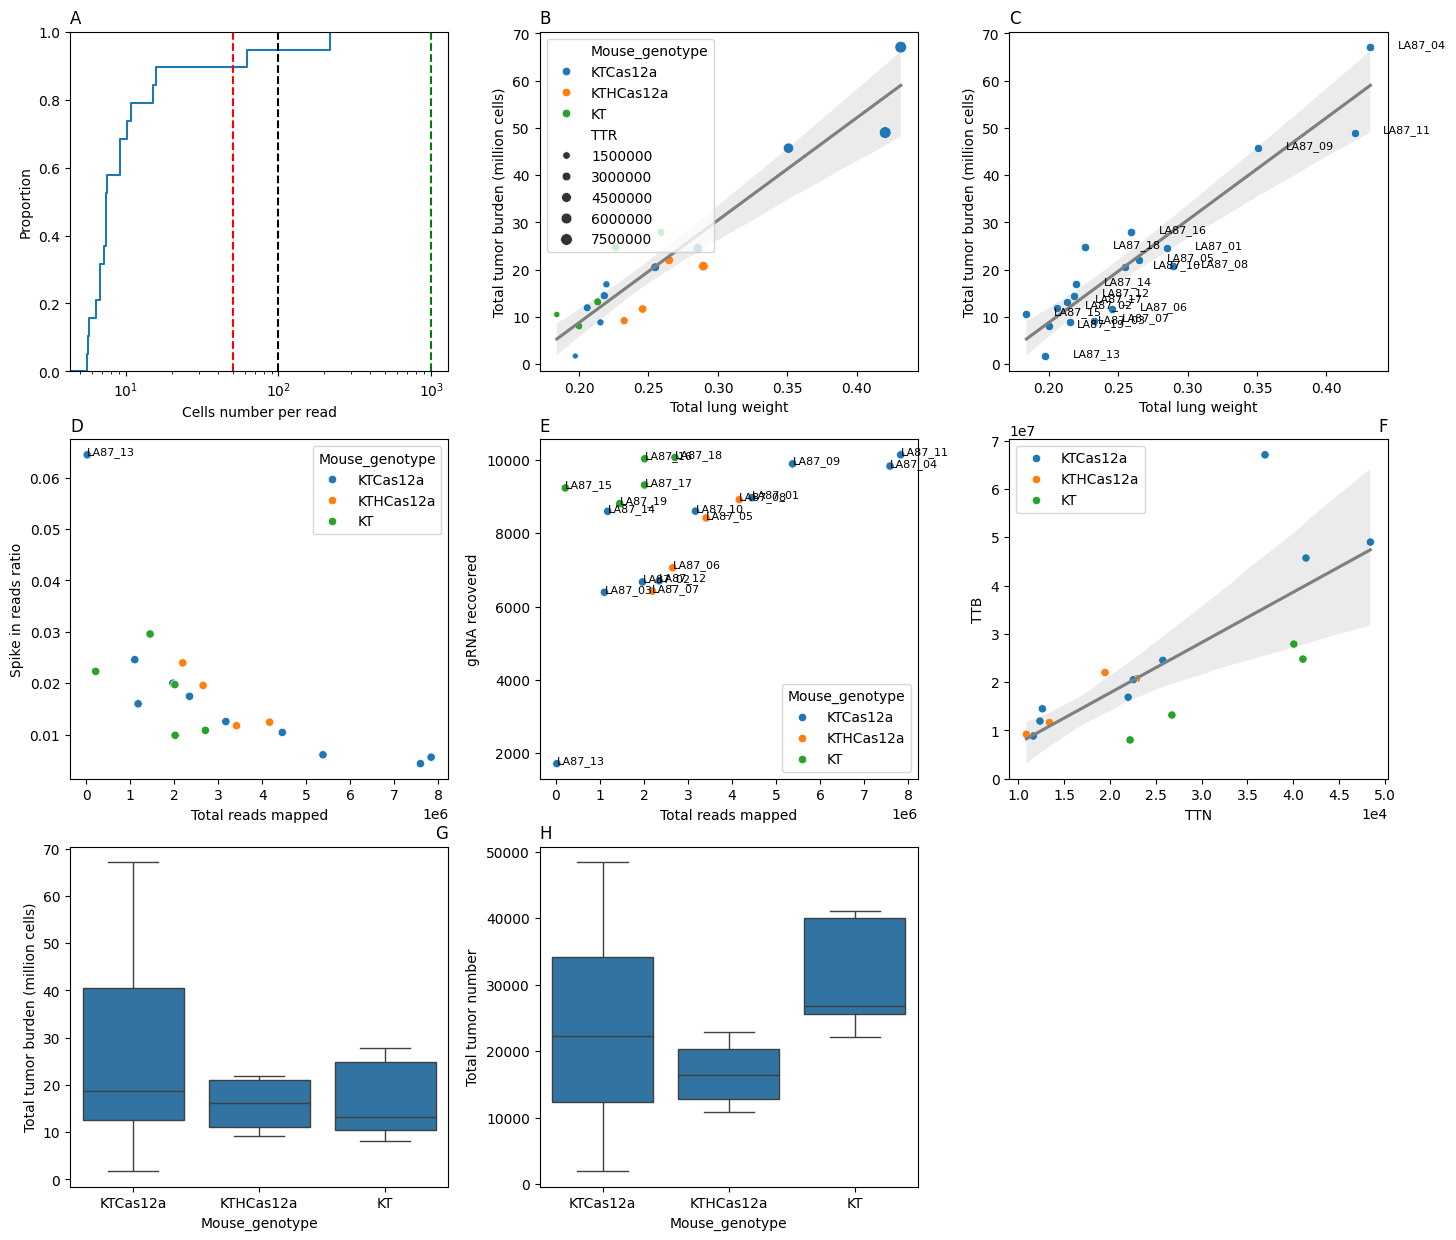

In [51]:
gs = gridspec.GridSpec(3, 17) 
fig1 = plt.figure(figsize=(17,15))

ax1=fig1.add_subplot(gs[:1, 0:5])
temp_df = Sample_summary_df
sns.ecdfplot(data=temp_df, x="Cell_number_per_read",ax = ax1)
ax1.set_xlabel('Cells number per read')
ax1.set_xscale('log')
ax1.axvline(50,color='red', linestyle='--')
ax1.axvline(100,color='black', linestyle='--')
ax1.axvline(1000,color='green', linestyle='--')
ax1.set_title('A', loc ='left')


ax2=fig1.add_subplot(gs[:1, 6:11])
temp_df = Sample_summary_df[(Sample_summary_df['Total_lung_weight']!= 0)&(~Sample_summary_df['TTB_million'].isna())]
sns.regplot(x='Total_lung_weight', y='TTB_million', data=temp_df, fit_reg=True ,ax= ax2,scatter=False,color = 'tab:grey')
sns.scatterplot(x='Total_lung_weight', y='TTB_million', data=temp_df, hue = 'Mouse_genotype',ax = ax2,size= 'TTR')
# label_point(temp_df['Total_lung_weight'], temp_df['TTB_million'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax2.set_xlabel('Total lung weight')
ax2.set_ylabel('Total tumor burden (million cells)')
ax2.set_title('B', loc ='Left')

ax3=fig1.add_subplot(gs[:1, 12:17])
sns.regplot(x='Total_lung_weight', y='TTB_million', data=temp_df, fit_reg=True ,ax= ax3,scatter=False,color = 'tab:grey')
sns.scatterplot(x='Total_lung_weight', y='TTB_million', data=temp_df, ax = ax3)
label_point(temp_df['Total_lung_weight'], temp_df['TTB_million'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax3.set_xlabel('Total lung weight')
ax3.set_ylabel('Total tumor burden (million cells)')
ax3.set_title('C', loc ='Left')


ax4 = fig1.add_subplot(gs[1:2, 0:5])
sns.scatterplot(x='TTR', y='Spikein_read_ratio', data=Sample_summary_df, hue='Mouse_genotype', ax= ax4)
temp_df = Sample_summary_df[Sample_summary_df.TTR<100000] # < 0.1 million reads
label_point(temp_df['TTR'], temp_df['Spikein_read_ratio'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
# ax4.set_yscale('log')
ax4.set_title('D', loc ='Left')
ax4.set_xlabel('Total reads mapped')
ax4.set_ylabel('Spike in reads ratio')

ax5 = fig1.add_subplot(gs[1:2, 6:11])

sns.scatterplot(x='TTR', y='array_recovered',data=Sample_summary_df,hue='Mouse_genotype', ax= ax5)

temp_df = Sample_summary_df[Sample_summary_df.array_recovered<len(anotated_df.gRNA_combination.unique())*0.98] # < 1 million reads
label_point(temp_df['TTR'], temp_df['array_recovered'], temp_df['Sample_ID'], plt.gca()) # this is for labeling

ax5.set_xlabel('Total reads mapped')
ax5.set_ylabel('gRNA recovered')
ax5.set_title('E', loc ='left')


temp_df = Sample_summary_df[Sample_summary_df.TTR>1000000] # I request at least 1 million reads
ax6 = fig1.add_subplot(gs[1:2, 12:17])
sns.regplot(x='TTN', y='TTB', data=temp_df, fit_reg=True ,ax= ax6,scatter=False,color = 'tab:grey')
sns.scatterplot(x='TTN', y='TTB', data=temp_df, hue='Mouse_genotype', ax= ax6)
# ax6.set_yscale('log')
ax6.set_title('F', loc ='Right')
ax6.set_xlabel('TTN')
ax6.set_ylabel('TTB')
# ax6.xaxis.major.formatter._useMathText = True
ax6.ticklabel_format(axis='both',style='sci',scilimits=(-3,4))
ax6.legend(loc='upper left')


ax7 = fig1.add_subplot(gs[2:3, :5])
# sns.boxplot(x='Virus_titer', y='TTB_million', data=Sample_summary_df, hue=Sample_summary_df[['Mouse_genotype','Sex']].apply(tuple, axis=1), ax= ax7)
sns.boxplot(x='Mouse_genotype', y='TTB_million', data=Sample_summary_df, ax= ax7)
ax7.set_title('G', loc ='right')
ax7.set_ylabel('Total tumor burden (million cells)')

ax8 = fig1.add_subplot(gs[2:3, 6:11])
# sns.boxplot(x='Virus_titer', y='TTN', data=Sample_summary_df, hue=Sample_summary_df[['Mouse_genotype','Sex']].apply(tuple, axis=1), ax= ax8)
sns.boxplot(x='Mouse_genotype', y='TTN', data=Sample_summary_df,  ax= ax8)
ax8.set_title('H', loc ='Left')
ax8.set_ylabel('Total tumor number')
# fig1.savefig(figure_output_address+'xxx.pdf')

### 7.4 Nomination sample to exclude

In [52]:
Sample_summary_df.sort_values(by='TTN')

,Sample_ID,array_recovered,TTB,TTN,TTB_million,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio
12,LA87_13,1716.0,1.728355e+06,1959.0,1.728355,KTCas12a,M,7.0,0.1973,500000.0,No,216.450216,20111,462.000000,1.095023,0.064474
6,LA87_07,6424.0,9.193868e+06,10902.0,9.193868,KTHCas12a,F,7.0,0.2325,500000.0,No,5.583265,2190509,17910.666667,1.232134,0.023942
2,LA87_03,6392.0,8.843576e+06,11643.0,8.843576,KTCas12a,F,7.0,0.2154,500000.0,No,10.814708,1100785,9246.666667,1.163934,0.024581
1,LA87_02,6673.0,1.193442e+07,12377.0,11.934423,KTCas12a,F,7.0,0.2059,500000.0,No,7.481670,1964810,13366.000000,1.320799,0.020000
11,LA87_12,6704.0,1.448815e+07,12639.0,14.488146,KTCas12a,F,7.0,0.2182,500000.0,No,7.209112,2344623,13871.333333,1.257412,0.017439
5,LA87_06,7059.0,1.167173e+07,13406.0,11.671734,KTHCas12a,M,7.0,0.2458,500000.0,No,5.667970,2652824,17643.000000,1.280387,0.019562
4,LA87_05,8418.0,2.199398e+07,19466.0,21.993983,KTHCas12a,M,7.0,0.2648,500000.0,No,7.412532,3413085,13490.666667,1.164841,0.011719
13,LA87_14,8601.0,1.689111e+07,21989.0,16.891115,KTCas12a,F,7.0,0.2197,500000.0,No,15.698587,1176650,6370.000000,1.212060,0.015981
18,LA87_19,8812.0,8.039355e+06,22204.0,8.039355,KT,M,7.0,0.2000,666666.0,No,6.794248,1448730,14718.333333,1.341870,0.029577
9,LA87_10,8606.0,2.049897e+07,22549.0,20.498973,KTCas12a,M,7.0,0.2548,500000.0,No,7.462872,3169321,13399.666667,1.209077,0.012525


In [53]:
f1 = Sample_summary_df[Sample_summary_df['Cell_number_per_read']>200]['Sample_ID'] # read depth
f2 = Sample_summary_df[Sample_summary_df['Spikein_read_ratio']>0.5]['Sample_ID']
f3 = Sample_summary_df[Sample_summary_df['TTR']<100000]['Sample_ID'] # total read depth 

In [54]:
sample_to_throw = list(set(f1)|set(f2)|set(f3))

In [18]:
sample_to_throw = ['LA87_13']

In [55]:
print(sample_to_throw)

['LA87_13']


<font size="10" color =  red> Sample LA87_13 is excluded because insufficency sequencing </font>

---

## 8 Contamination analysis

### 8.1 Data processing

In [19]:
input_df = anotated_df[anotated_df.Array_category!='Spikein']
input_df = input_df[~input_df.Sample_ID.isin(sample_to_throw)].copy()
input_df['gRNA_clonalbarcode'] = input_df['gRNA_combination'] + '_' + input_df['Clonal_barcode']

In [58]:
temp = input_df.groupby('Sample_ID')['Count'].count()
ref_dict = dict(zip(temp.index, temp.values))

In [59]:
# Step 1: Group by Sample_ID and collect unique gRNA_clonalbarcode values for each Sample_ID
sample_barcodes = input_df.groupby('Sample_ID')['gRNA_clonalbarcode'].apply(set).to_dict()

# Step 2: Get all unique Sample_IDs
sample_ids = list(sample_barcodes.keys())

# Step 3: Initialize an empty DataFrame to store the shared fractions
shared_fraction_df = pd.DataFrame(index=sample_ids, columns=sample_ids)

# Step 4: Calculate the shared fraction of gRNA_clonalbarcode in row Sample_ID (i) with column Sample_ID (j)
for id1 in sample_ids:
    for id2 in sample_ids:
        if id1 == id2:
            shared_fraction_df.loc[id1, id2] = 1.0  # Full overlap with itself
        else:
            # Calculate intersection and the total unique gRNA_clonalbarcode count for Sample_ID id1
            intersection = sample_barcodes[id1].intersection(sample_barcodes[id2])
            shared_fraction = len(intersection) / len(sample_barcodes[id1]) if sample_barcodes[id1] else 0
            shared_fraction_df.loc[id1, id2] = shared_fraction

# Convert all values to numeric
shared_fraction_df = shared_fraction_df.apply(pd.to_numeric)
# Convert the DataFrame to long format
shared_fraction_long_df = shared_fraction_df.reset_index().melt(id_vars='index', var_name='Sample_ID_j', value_name='shared_fraction')
shared_fraction_long_df.rename(columns={'index': 'Sample_ID_i'}, inplace=True)

# Remove rows where Sample_ID_i is equal to Sample_ID_j
# shared_fraction_long_df = shared_fraction_long_df[shared_fraction_long_df['Sample_ID_i'] != shared_fraction_long_df['Sample_ID_j']]
shared_fraction_long_df['Tumor_number_i'] = shared_fraction_long_df.Sample_ID_i.apply(lambda x: ref_dict.get(x))
shared_fraction_long_df['Tumor_number_j'] = shared_fraction_long_df.Sample_ID_j.apply(lambda x: ref_dict.get(x))



### 8.2 Simple relationship

Text(0.4, 0.85, 'P-value = 0.13')

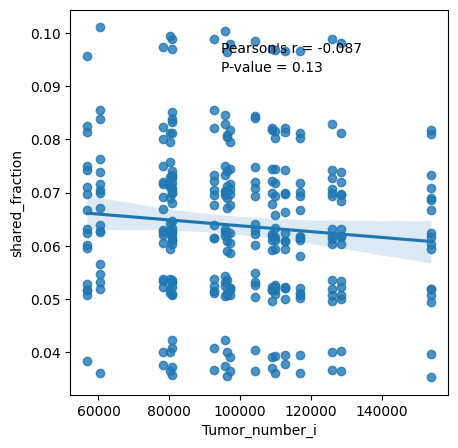

In [60]:
gs = gridspec.GridSpec(5, 17) 
fig1 = plt.figure(figsize=(17,5))


# xtitle = 'Tumor fraction in K mice'
# ytitle = 'sgRNA reads fraction in plasmid library'

ax1=fig1.add_subplot(gs[:5, 0:5])
temp_df = shared_fraction_long_df[shared_fraction_long_df.shared_fraction!=1]
iy = 'shared_fraction'
ix = 'Tumor_number_i'
sns.regplot(x=ix, y=iy, data=temp_df, fit_reg=True ,ax= ax1)

temp1 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[0]
temp2 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[1]
ax1.text(0.40,0.9, "Pearson's r = "+str(round(temp1,3)), size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)
ax1.text(0.40,0.85, f"P-value = {temp2:.2f}", size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)

Text(0.4, 0.85, 'P-value = 0.00')

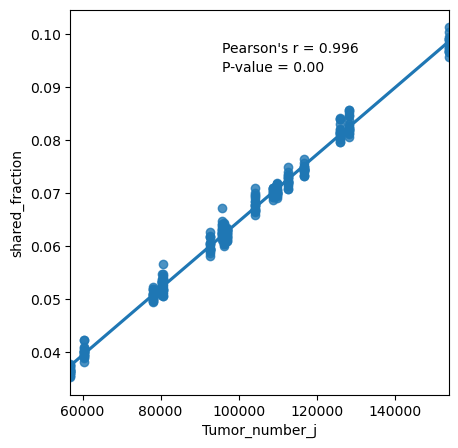

In [79]:
gs = gridspec.GridSpec(5, 17) 
fig1 = plt.figure(figsize=(17,5))


# xtitle = 'Tumor fraction in K mice'
# ytitle = 'sgRNA reads fraction in plasmid library'

ax1=fig1.add_subplot(gs[:5, 0:5])
temp_df = shared_fraction_long_df[shared_fraction_long_df.shared_fraction!=1]
iy = 'shared_fraction'
ix = 'Tumor_number_j'
sns.regplot(x=ix, y=iy, data=temp_df, fit_reg=True ,ax= ax1)

temp1 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[0]
temp2 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[1]
ax1.text(0.40,0.9, "Pearson's r = "+str(round(temp1,3)), size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)
ax1.text(0.40,0.85, f"P-value = {temp2:.2f}", size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)

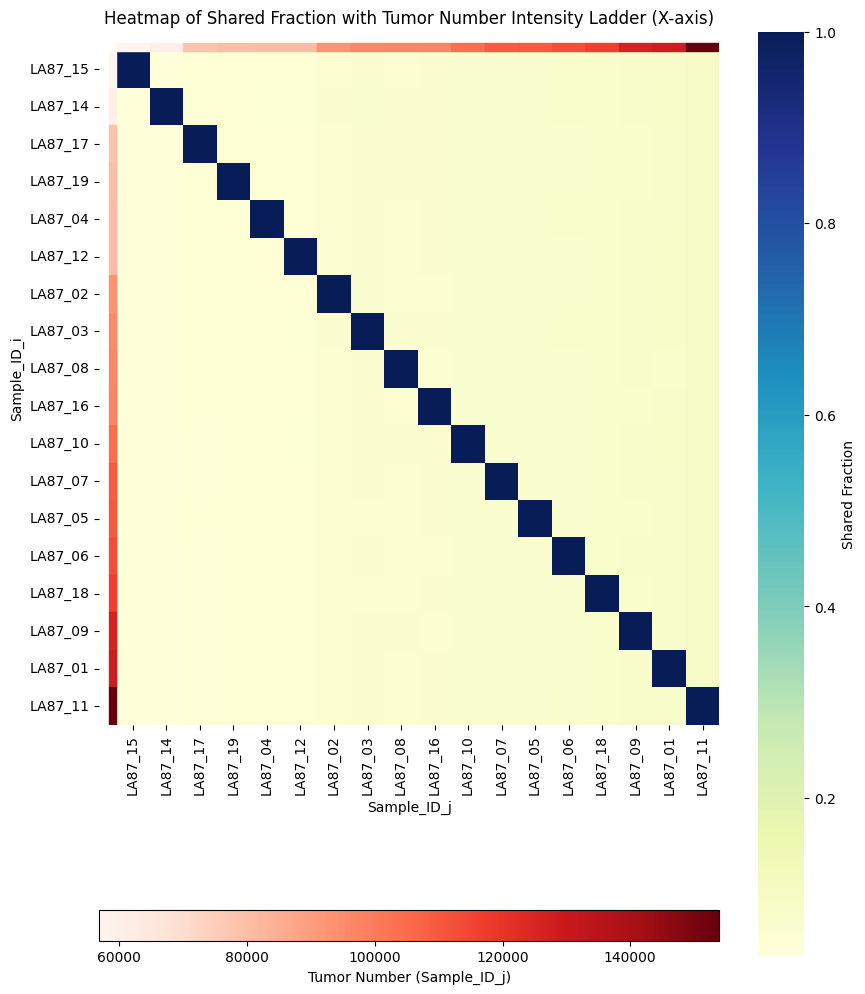

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sort the DataFrame by Tumor_number_i and Tumor_number_j
sorted_df = shared_fraction_long_df.sort_values(['Tumor_number_i', 'Tumor_number_j'])

# Create a pivot table for the heatmap, sorted by Sample_IDs
heatmap_data = sorted_df.pivot(index='Sample_ID_i', columns='Sample_ID_j', values='shared_fraction')

# Ensure rows and columns are sorted based on Tumor_number
heatmap_data = heatmap_data.loc[sorted_df['Sample_ID_i'].unique(), sorted_df['Sample_ID_j'].unique()]

# Extract Tumor_number_i and Tumor_number_j values in the order of sorted Sample_IDs
tumor_number_i = sorted_df.drop_duplicates('Sample_ID_i').set_index('Sample_ID_i')['Tumor_number_i']
tumor_number_j = sorted_df.drop_duplicates('Sample_ID_j').set_index('Sample_ID_j')['Tumor_number_j']

# Plot the main heatmap
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Shared Fraction'},
    ax=ax, xticklabels=True, yticklabels=True
)
# Create colorbars (ladders) for Tumor_number_i (y-axis) and Tumor_number_j (x-axis)
# Normalize the tumor numbers for consistent color mapping
norm_i = plt.Normalize(tumor_number_i.min(), tumor_number_i.max())
norm_j = plt.Normalize(tumor_number_j.min(), tumor_number_j.max())
cmap_i = plt.cm.Reds
cmap_j = plt.cm.Reds

# Adjust thickness for ladders (0.3 width for y-axis ladder, 0.3 height for x-axis ladder)
ladder_thickness_y = 0.2
ladder_thickness_x = 0.2

# Add the ladder for Tumor_number_i on the left side
for i, value in enumerate(tumor_number_i):
    ax.add_patch(plt.Rectangle((-ladder_thickness_y, i), ladder_thickness_y, 1, color=cmap_i(norm_i(value))))

# Add the ladder for Tumor_number_j on the top
for j, value in enumerate(tumor_number_j):
    ax.add_patch(plt.Rectangle((j, -ladder_thickness_x), 1, ladder_thickness_x, color=cmap_j(norm_j(value))))

# Adjust plot limits to make space for the x-axis ladder
ax.set_ylim(len(heatmap_data), -0.5)
ax.set_xlim(-0.5, len(tumor_number_j))

# Add a color bar for the x-axis ladder legend
sm = plt.cm.ScalarMappable(cmap=cmap_j, norm=norm_j)
sm.set_array([])  # We don't actually need data here
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.2, fraction=0.05)
cbar.set_label('Tumor Number (Sample_ID_j)')

# Show plot
plt.title("Heatmap of Shared Fraction with Tumor Number Intensity Ladder (X-axis)")
plt.show()


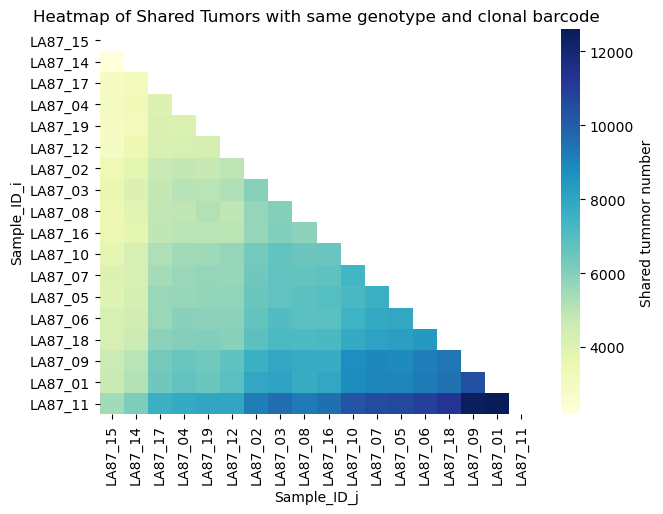

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sort the DataFrame by Tumor_number_i and Tumor_number_j
sorted_df = shared_fraction_long_df.sort_values(['Tumor_number_i', 'Tumor_number_j']).copy()
sorted_df['Shared_tummor'] = sorted_df['shared_fraction'] * sorted_df['Tumor_number_i']

# Create a pivot table for the heatmap, sorted by Sample_IDs
heatmap_data = sorted_df.pivot(index='Sample_ID_i', columns='Sample_ID_j', values='Shared_tummor')

# Ensure rows and columns are sorted based on Tumor_number
heatmap_data = heatmap_data.loc[sorted_df['Sample_ID_i'].unique(), sorted_df['Sample_ID_j'].unique()]

# Extract Tumor_number_i and Tumor_number_j values in the order of sorted Sample_IDs
tumor_number_i = sorted_df.drop_duplicates('Sample_ID_i').set_index('Sample_ID_i')['Tumor_number_i']
tumor_number_j = sorted_df.drop_duplicates('Sample_ID_j').set_index('Sample_ID_j')['Tumor_number_j']

# Mask the upper triangle of the heatmap (only show lower triangle)
mask = np.triu(np.ones(heatmap_data.shape, dtype=bool))

# Plot the main heatmap
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    heatmap_data, mask=mask, cmap='YlGnBu', cbar_kws={'label': 'Shared tummor number'},
    ax=ax, xticklabels=True, yticklabels=True
)


# Show plot
plt.title("Heatmap of Shared Tumors with same genotype and clonal barcode")
plt.show()
# fig.savefig(temp_out_address4_1)


/home/xhq/miniconda3/envs/UltraSeq/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


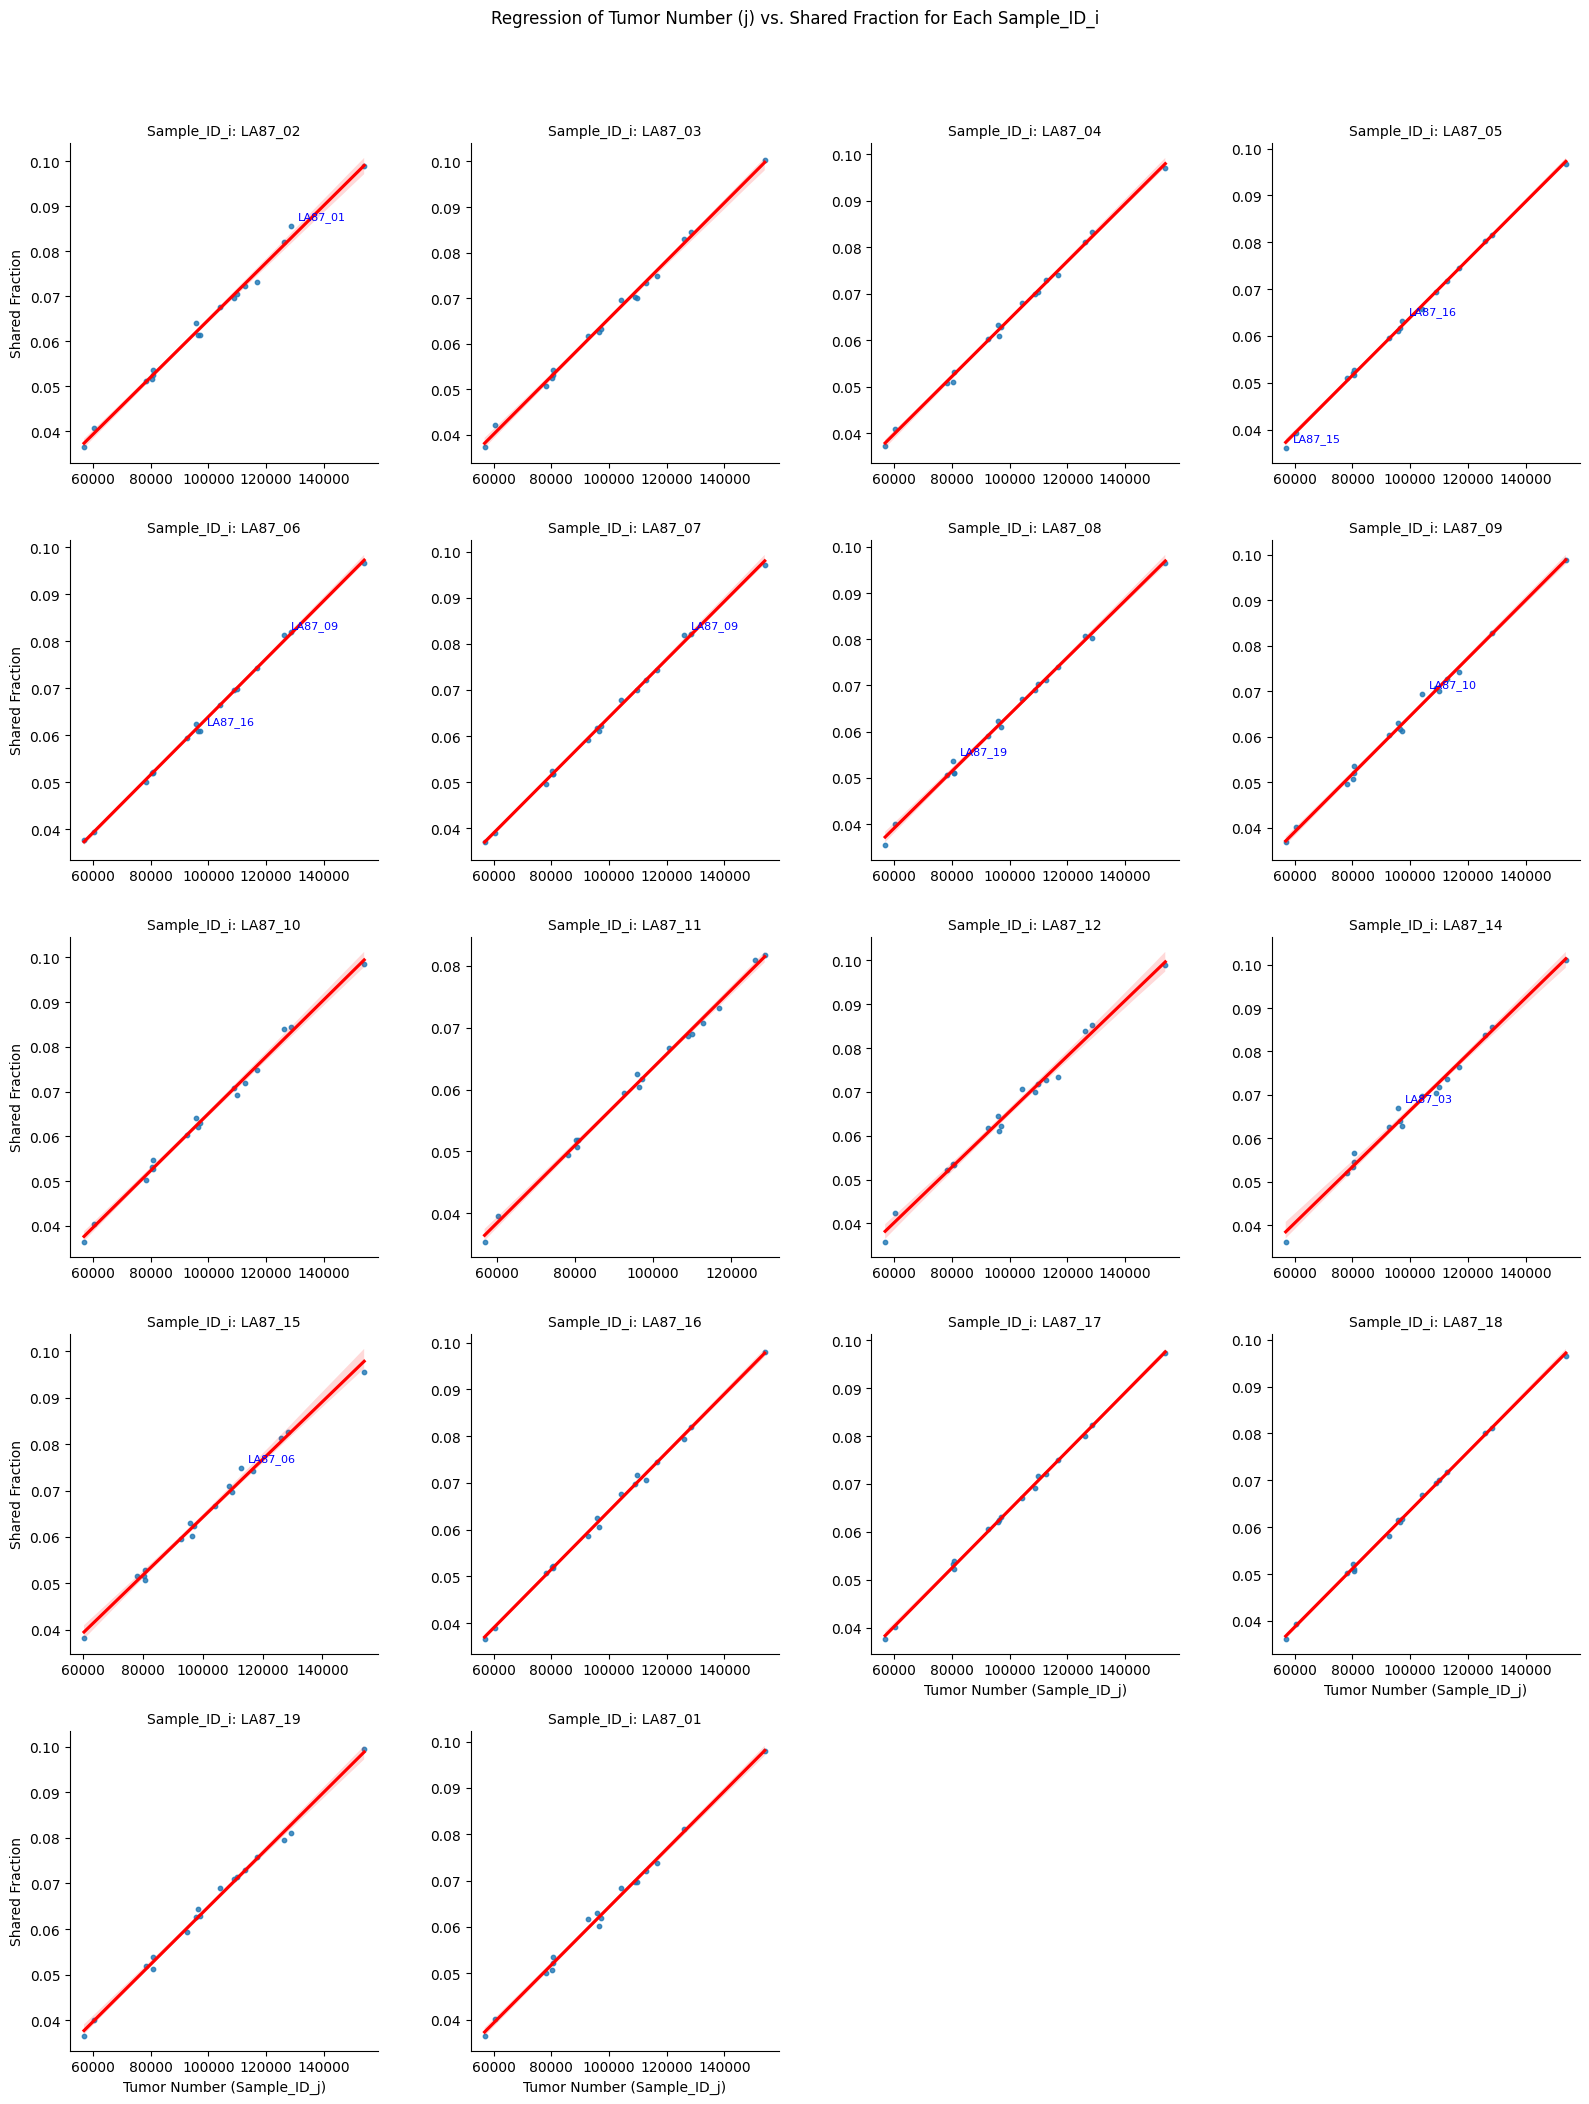

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Filter the data as in your original code
query_df = shared_fraction_long_df[shared_fraction_long_df['Sample_ID_i'] != shared_fraction_long_df['Sample_ID_j']]

# Define a function to plot and annotate outliers
def annotate_outliers(data, **kwargs):
    ax = plt.gca()
    
    # Scatter plot and regression line
    sns.regplot(x="Tumor_number_j", y="shared_fraction", data=data, ax=ax, 
                scatter_kws={'s': 10}, line_kws={'color': 'red'})
    
    # Fit a regression model
    X = data["Tumor_number_j"].values.reshape(-1, 1)
    y = data["shared_fraction"].values
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict(X)
    
    # Calculate residuals and standard deviation of residuals
    residuals = y - predictions
    std_residuals = np.std(residuals)
    
    # Identify points beyond confidence interval (±2 standard deviations)
    outliers = np.abs(residuals) > 2 * std_residuals
    outlier_points = data[outliers]
    
    # Annotate outliers with Sample_ID_i
    for _, row in outlier_points.iterrows():
        ax.annotate(row['Sample_ID_j'], (row['Tumor_number_j'], row['shared_fraction']), 
                    textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8, color='blue')

# Set up the FacetGrid to create a separate plot for each Sample_ID_i
g = sns.FacetGrid(query_df, col="Sample_ID_i", col_wrap=4, height=4, sharex=False, sharey=False)

# Apply the custom function to each facet
g.map_dataframe(annotate_outliers)

# Adjust labels and titles
g.set_axis_labels("Tumor Number (Sample_ID_j)", "Shared Fraction")
g.set_titles("Sample_ID_i: {col_name}")
g.fig.suptitle("Regression of Tumor Number (j) vs. Shared Fraction for Each Sample_ID_i", y=1.05)

# Show plot
plt.show()


### 8.3 quadratic fit

Regression Coefficients:
Tumor_number_j coefficient: -0.0008
Tumor_number_i coefficient: -0.0017
Interaction term coefficient: 0.0000
Intercept: 281.9699


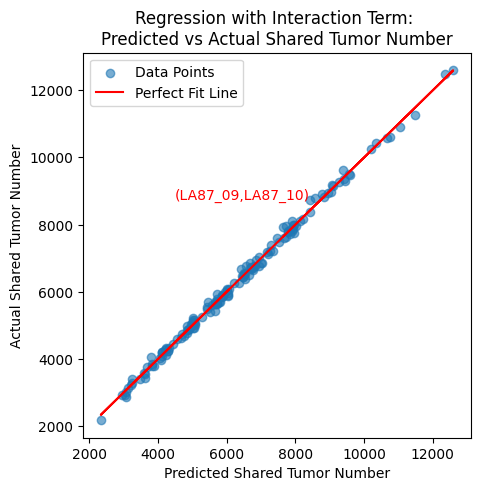

10-Fold Cross-Validation MSE: 12622.7471 ± 6530.7289
10-Fold Cross-Validation R^2: 0.9959 ± 0.0020


In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Prepare the data for regression
# Calculate shared tumor and filter out diagonal comparisons
query_df = shared_fraction_long_df.copy()
query_df['Shared_tummor'] = query_df['shared_fraction'] * query_df['Tumor_number_i']
query_df = query_df[query_df['Sample_ID_i'] != query_df['Sample_ID_j']]

# Eliminate reciprocal cases
query_df[['Sample_ID_i', 'Sample_ID_j']] = np.sort(query_df[['Sample_ID_i', 'Sample_ID_j']].values, axis=1)
query_df = query_df.drop_duplicates(subset=['Sample_ID_i', 'Sample_ID_j'])

# Remove missing values and reset the index
df = query_df.dropna().reset_index()

# Define independent variables (Tumor_number_i, Tumor_number_j) and target (Shared_tummor)
X = df[['Tumor_number_j', 'Tumor_number_i']].copy()  # Make a copy to avoid SettingWithCopyWarning
y = df['Shared_tummor']

# Add interaction term (Tumor_number_j * Tumor_number_i)
X['Interaction'] = X['Tumor_number_j'] * X['Tumor_number_i']


# Fit the multiple linear regression model with interaction term
model = LinearRegression()
model.fit(X, y)

# Get predictions and residuals
predicted = model.predict(X)
residuals = y - predicted

# Determine threshold for outliers (e.g., 3 standard deviations from the mean residual)
threshold = 3 * np.std(residuals)

# Identify outliers
outliers = df[np.abs(residuals) > threshold].copy()
outliers['Predicted_shared_tumor'] = predicted[outliers.index]

# Print regression coefficients for interpretation
print("Regression Coefficients:")
print(f"Tumor_number_j coefficient: {model.coef_[0]:.4f}")
print(f"Tumor_number_i coefficient: {model.coef_[1]:.4f}")
print(f"Interaction term coefficient: {model.coef_[2]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

# Scatter plot: Predicted vs Actual Shared Tumor Number
plt.figure(figsize=(5, 5))
plt.scatter(predicted, y, label="Data Points", alpha=0.6)
plt.plot(predicted, predicted, color="red", label="Perfect Fit Line")

# Label outliers with Sample_ID pairs (i, j)
for _, row in outliers.iterrows():
    ti = row["Sample_ID_i"]
    tj = row["Sample_ID_j"]
    plt.text(predicted[row.name], row["Shared_tummor"], f"({ti},{tj})", fontsize=10, color="red", ha="right")

# Plot settings
plt.xlabel("Predicted Shared Tumor Number")
plt.ylabel("Actual Shared Tumor Number")
plt.title("Regression with Interaction Term: \nPredicted vs Actual Shared Tumor Number")
plt.legend()
# plt.savefig(temp_out_address4_2)
plt.show()

# Define scoring functions for cross-validation
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

# Perform 10-fold cross-validation
cv_results = cross_validate(model, X, y, scoring=scoring, cv=10)

# Calculate mean and standard deviation of cross-validation MSE and R^2 scores
mean_mse = -cv_results['test_MSE'].mean()  # Convert negative MSE back to positive
std_mse = cv_results['test_MSE'].std()
mean_r2 = cv_results['test_R2'].mean()
std_r2 = cv_results['test_R2'].std()

# Print cross-validation results
print(f"10-Fold Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"10-Fold Cross-Validation R^2: {mean_r2:.4f} ± {std_r2:.4f}")


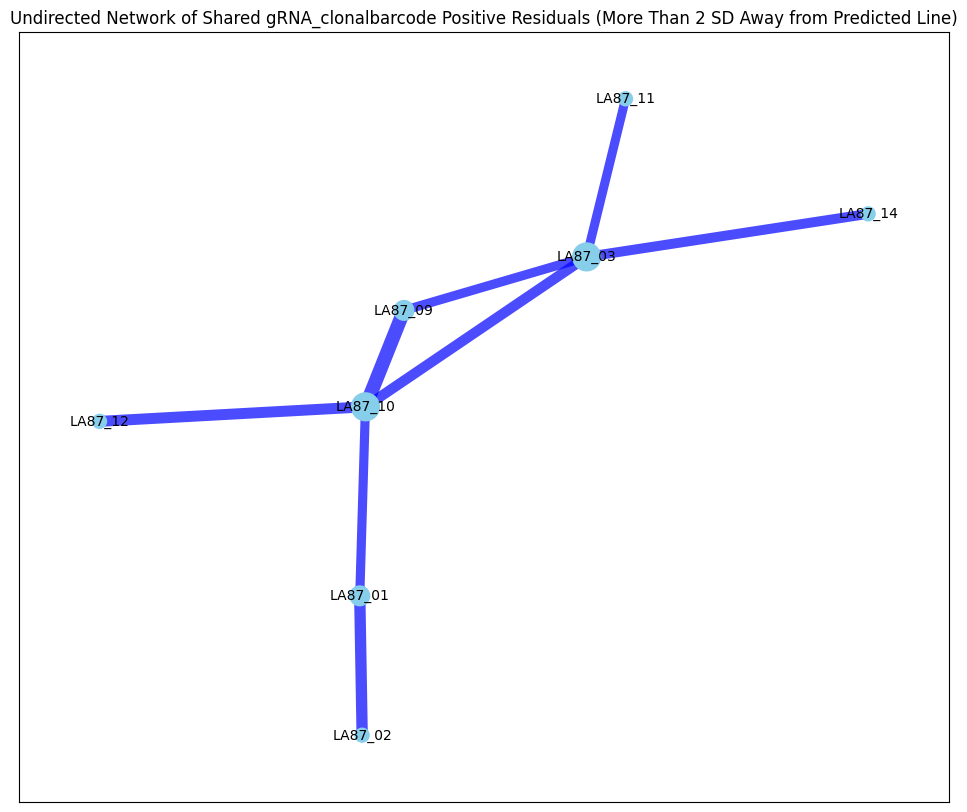

In [69]:
import networkx as nx
from sklearn.linear_model import LinearRegression

# Assuming shared_fraction_long_df is already defined in the environment
query_df = shared_fraction_long_df.copy()
query_df['Shared_tummor'] = query_df['shared_fraction'] * query_df['Tumor_number_i']
query_df = query_df[query_df['Sample_ID_i'] != query_df['Sample_ID_j']]

# Eliminate reciprocal cases
query_df[['Sample_ID_i', 'Sample_ID_j']] = np.sort(query_df[['Sample_ID_i', 'Sample_ID_j']].values, axis=1)
query_df = query_df.drop_duplicates(subset=['Sample_ID_i', 'Sample_ID_j'])

# Remove missing values and reset the index
df = query_df.dropna().reset_index()

# Define independent variables (Tumor_number_i, Tumor_number_j) and target (Shared_tummor)
X = df[['Tumor_number_j', 'Tumor_number_i']].copy()  # Make a copy to avoid SettingWithCopyWarning
y = df['Shared_tummor']

# Add interaction term (Tumor_number_j * Tumor_number_i)
X['Interaction'] = X['Tumor_number_j'] * X['Tumor_number_i']

# Fit the linear Regressor model
model = LinearRegression()
model.fit(X, y)

# Get predictions and residuals
predicted = model.predict(X)
residuals = y - predicted

df['residual'] = residuals

# Calculate mean and standard deviation of residuals
mean_residual = df['residual'].mean()
std_residual = df['residual'].std()

# Define the threshold for filtering (2 standard deviations from the predicted line)
threshold = 2 * std_residual

# Filter DataFrame for positive residuals more than 2 standard deviations away from the predicted line
filtered_df_positive = df[df['residual'] > threshold]

# Initialize an undirected graph
G = nx.Graph()

# Add edges with weights for pairs that meet the positive threshold
for _, row in filtered_df_positive.iterrows():
    G.add_edge(row['Sample_ID_i'], row['Sample_ID_j'], weight=row['residual'], color='blue')

# Plot the undirected network graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)  # Use spring layout for visual appeal

# Normalize edge weights for visualization
max_weight = max([data['weight'] for _, _, data in G.edges(data=True)]) if len(G.edges()) > 0 else 1
weights = [G[u][v]['weight'] / max_weight * 10 for u, v in G.edges()]  # Scale weights to a range (0-10)

# Draw nodes with size based on degree
node_sizes = [G.degree(node) * 100 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=node_sizes)

# Draw undirected edges with color for positive residuals
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos, edgelist=G.edges(), width=weights, alpha=0.7, edge_color=edge_colors
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Title and show plot
plt.title("Undirected Network of Shared gRNA_clonalbarcode Positive Residuals (More Than 2 SD Away from Predicted Line)")
plt.show()


In [73]:
filtered_df_positive

,index,Sample_ID_i,Sample_ID_j,shared_fraction,Tumor_number_i,Tumor_number_j,Shared_tummor,residual
0,1,LA87_01,LA87_02,0.085497,92635,128530,7920.0,273.989688
8,9,LA87_01,LA87_10,0.084450,104168,128530,8797.0,221.482729
38,44,LA87_03,LA87_09,0.063077,126052,95845,7951.0,222.460248
39,45,LA87_03,LA87_10,0.064050,104168,95845,6672.0,249.460128
40,46,LA87_03,LA87_11,0.062440,153972,95845,9614.0,219.242158
42,48,LA87_03,LA87_14,0.067070,60325,95845,4046.0,239.935762
108,153,LA87_09,LA87_10,0.083980,104168,126052,8748.0,335.709836
118,173,LA87_10,LA87_12,0.070767,80659,104168,5708.0,265.415242


### 8.4 Examples 1

In [74]:
test_sample = ['LA87_09','LA87_10']
query_df = input_df[input_df.Sample_ID.isin(test_sample)].copy()
query_df['Log10CN'] = np.log10(query_df['Cell_number'])
temp = pd.pivot_table(query_df, values = 'Log10CN', index=['gRNA_clonalbarcode','gRNA_combination'], columns = 'Sample_ID').reset_index()
re_shaped_df = temp[~temp.isnull().any(axis=1)]

In [75]:
df1 = query_df[query_df.Sample_ID==test_sample[0]].copy()
df2 = query_df[query_df.Sample_ID==test_sample[1]].copy()
df1['Kind'] = 'Unique'
df1.loc[df1.gRNA_clonalbarcode.isin(df2.gRNA_clonalbarcode),'Kind']='Shared'

df2['Kind'] = 'Unique'
df2.loc[df2.gRNA_clonalbarcode.isin(df1.gRNA_clonalbarcode),'Kind']='Shared'

/home/xhq/miniconda3/envs/UltraSeq/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


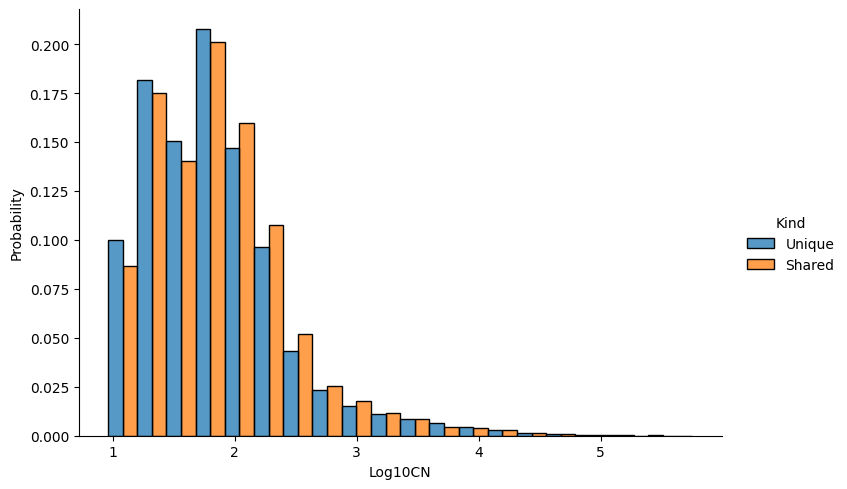

In [76]:
temp_df = df1.copy()
ax = sns.displot(data=temp_df, x="Log10CN", kind="hist", bins = 20,hue = 'Kind',
                 common_norm = False, aspect = 1.5,log_scale = [False,False],stat='probability',multiple = 'dodge' )

/home/xhq/miniconda3/envs/UltraSeq/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


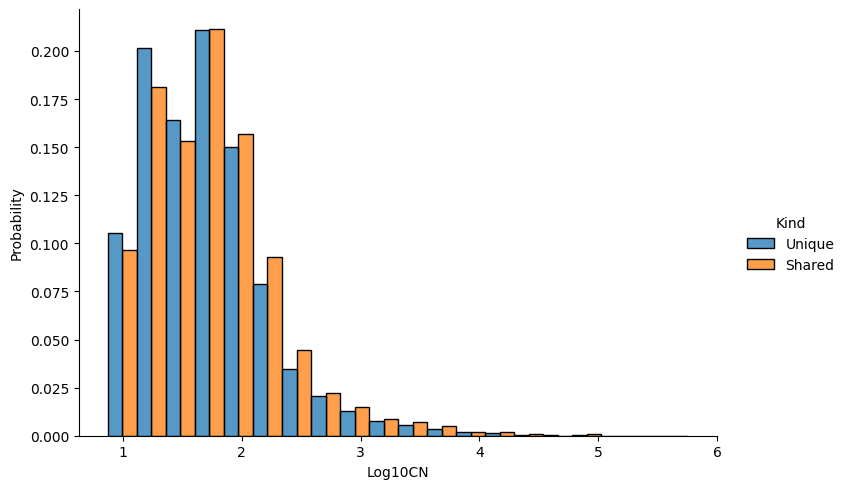

In [77]:
temp_df = df2.copy()
ax = sns.displot(data=temp_df, x="Log10CN", kind="hist", bins = 20,hue = 'Kind',
                 common_norm = False, aspect = 1.5,log_scale = [False,False],stat='probability',multiple = 'dodge' )

Text(0.4, 0.85, 'P-value = 0.00')

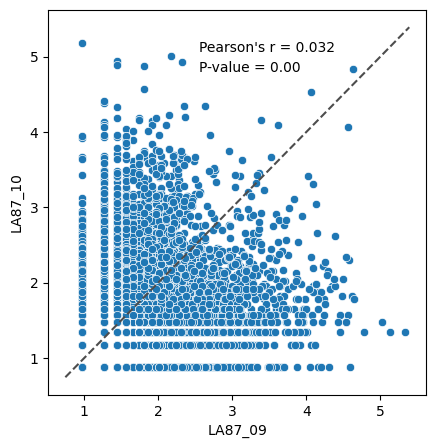

In [78]:
gs = gridspec.GridSpec(5, 17) 
fig1 = plt.figure(figsize=(17,5))


# xtitle = 'Tumor fraction in K mice'
# ytitle = 'sgRNA reads fraction in plasmid library'

ax1=fig1.add_subplot(gs[:5, 0:5])
temp_df = re_shaped_df
ix = test_sample[0]
iy = test_sample[1]
sns.scatterplot(x=ix, y=iy, data=temp_df,ax= ax1)
# ax1.set_xlabel(xtitle)
# ax1.set_ylabel(ytitle)
temp1 = max(ax1.get_xlim()[0],ax1.get_ylim()[0])
temp2 = min(ax1.get_xlim()[1],ax1.get_ylim()[1])
diag_line, = ax1.plot((temp1,temp2),(temp1,temp2), ls="--", c=".3")
temp1 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[0]
temp2 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[1]
ax1.text(0.40,0.9, "Pearson's r = "+str(round(temp1,3)), size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)
ax1.text(0.40,0.85, f"P-value = {temp2:.2f}", size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)

## 9 Output data for bootstrapping analysis

In [20]:
Final_data = anotated_df[anotated_df.Array_category!='Spikein']
Final_data = Final_data[~Final_data.Sample_ID.isin(sample_to_throw)]
Final_data['Type'] = 'Experiment'
Final_data.loc[Final_data.Array_category=='Triple_Inert','Type'] = 'Inert'

In [21]:
Final_data.to_parquet(final_data_output_address,index =False)

In [ ]:
Final_data

In [22]:
Final_data[['gRNA_combination','gRNA1','gRNA2','gRNA3','gRNA4','']]

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,gRNA3,Sample_ID,Count,Guide1,Guide2,Guide3,Gene1,Gene2,Gene3,Array_category,crRNA sequence,Array_count,DR1,DR2,DR3,DR6,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
0,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,TAAGCAATCCCTACAG,AAAGCATTCTTACCAGGATTCCA,AAAGTGATCAAGGACTACCCCTC,CAGACTTCCTCCAGAAGATATCC,LA87_18,1,Rb1_2,Tsc2_1,Trp53_1,Rb1,Tsc2,Trp53,Triple_TSG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATAAAGCATTCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,Rb1_Tsc2_Trp53,Rb1_Trp53_Tsc2,KT,666666.0,7.0,0.2263,M,Match,10.158816,No,10.158816,Experiment
1,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,TAAGTATTCGCGGACG,AAAGCATTCTTACCAGGATTCCA,AAAGTGATCAAGGACTACCCCTC,CAGACTTCCTCCAGAAGATATCC,LA87_18,8,Rb1_2,Tsc2_1,Trp53_1,Rb1,Tsc2,Trp53,Triple_TSG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATAAAGCATTCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,Rb1_Tsc2_Trp53,Rb1_Trp53_Tsc2,KT,666666.0,7.0,0.2263,M,Match,10.158816,No,81.270529,Experiment
2,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,TATAGAGGTACCGGTG,AAAGCATTCTTACCAGGATTCCA,AAAGTGATCAAGGACTACCCCTC,CAGACTTCCTCCAGAAGATATCC,LA87_18,2,Rb1_2,Tsc2_1,Trp53_1,Rb1,Tsc2,Trp53,Triple_TSG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATAAAGCATTCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,Rb1_Tsc2_Trp53,Rb1_Trp53_Tsc2,KT,666666.0,7.0,0.2263,M,Match,10.158816,No,20.317632,Experiment
3,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,TATCGAGGTACGTAAG,AAAGCATTCTTACCAGGATTCCA,AAAGTGATCAAGGACTACCCCTC,CAGACTTCCTCCAGAAGATATCC,LA87_18,1,Rb1_2,Tsc2_1,Trp53_1,Rb1,Tsc2,Trp53,Triple_TSG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATAAAGCATTCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,Rb1_Tsc2_Trp53,Rb1_Trp53_Tsc2,KT,666666.0,7.0,0.2263,M,Match,10.158816,No,10.158816,Experiment
4,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,TCCTTAAATTCCCTCG,AAAGCATTCTTACCAGGATTCCA,AAAGTGATCAAGGACTACCCCTC,CAGACTTCCTCCAGAAGATATCC,LA87_18,1,Rb1_2,Tsc2_1,Trp53_1,Rb1,Tsc2,Trp53,Triple_TSG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATAAAGCATTCT...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,AAAGCATTCTTACCAGGATTCCA_AAAGTGATCAAGGACTACCCCT...,Rb1_Tsc2_Trp53,Rb1_Trp53_Tsc2,KT,666666.0,7.0,0.2263,M,Match,10.158816,No,10.158816,Experiment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876154,TGTAGCTCAGTAAAAGTGAATGG_TGGCGGGAGTTAACTTAACATC...,TTTTTATAATCTGCCG,TGTAGCTCAGTAAAAGTGAATGG,TGGCGGGAGTTAACTTAACATCC,TCTGCTATGCATCCGGACAGTGT,LA87_01,6,Rb1_1,Arid1a_1,Tsc2_2,Rb1,Arid1a,Tsc2,Triple_TSG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATTGTAGCTCAG...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,TCTGCTATGCATCCGGACAGTGT_TGGCGGGAGTTAACTTAACATC...,Rb1_Arid1a_Tsc2,Arid1a_Rb1_Tsc2,KTCas12a,500000.0,7.0,0.2855,M,Match,6.404782,No,38.428693,Experiment
1876155,TGTAGCTCAGTAAAAGTGAATGG_TGGCGGGAGTTAACTTAACATC...,TCATTAATAGCCCTAG,TGTAGCTCAGTAAAAGTGAATGG,TGGCGGGAGTTAACTTAACATCC,TGCACGAGATGGGCCTATGTCCA,LA87_01,13,Rb1_1,Arid1a_1,Tet2_1,Rb1,Arid1a,Tet2,Triple_TSG,TAAGCACGTCTCTATGGAATTTCTACTCTTGTAGATTGTAGCTCAG...,1.0,AATTTCTACTCTTGTAGAT,AAATTTCTACTCTAGTAGAT,TAATTTCTACTGTCGTAGAT,AAATTTCTCCTCTAGGAGAT,TGCACGAGATGGGCCTATGTCCA_TGGCGGGAGTTAACTTAACATC...,Rb1_Arid1a_Tet2,Arid1a_Rb1_Tet2,KTCas12a,500000.0,7.0,0.2855,M,Match,6.404782,No,83.262169,Experiment
1876156,TGTAGCTCAGTAAAAGTGAATGG_TGGCGGGAGTTAACTTAACATC...,TCCCAACCAACGAGCG,TGTAGCTCA